***Постановка задачи***

Дана небольшая выборкой из коллекции подержанных автомобилей, выставленных на продажу в Соединённых Штатах. На этих данных нужно построить модель классификации, определяющую категорию цены подержанного автомобиля в зависимости от характеристик транспортного средства.

Описание датасета:
- `id`: идентификатор записи;
- `url`: URL записи о продаже;
- `region`: регион;
- `region_url`: URL региона;
- `price`: стоимость;
- `year`: год выпуска;
- `manufacturer`: производитель;
- `model`: модель;
- `condition`: состояние;
- `cylinders`: количество цилиндров;
- `fuel`: тип топлива;
- `odometer`: количество пройденных миль;
- `title_status`: статус;
- `transmission`: коробка передач;
- `VIN`: идентификационный номер;
- `drive`: тип привода;
- `size`: размер;
- `type`: кузов;
- `paint_color`: цвет;
- `image_url`: URL изображения;
- `description`: указанное описание;
- `county`: страна;
- `state`: штат;
- `lat`: широта;
- `long`: долгота;
- `posting_date`: дата размещения объявления о продаже;
- `price_category`: категория цены.

In [1]:
# Импорот сторонних библиотек
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import dill
import warnings

from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
warnings.simplefilter("ignore")

# Data Loading

In [3]:
# Закрузка данных
df = pd.read_csv('data/main_dataset.csv')
print(df.shape)
df.head()

(10000, 20)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


# Data Preparation

In [4]:
# Удалим дублирующие строки
df.drop_duplicates(inplace=True)

## Обработка пропусков

### Выявление пропусков во всем датасете

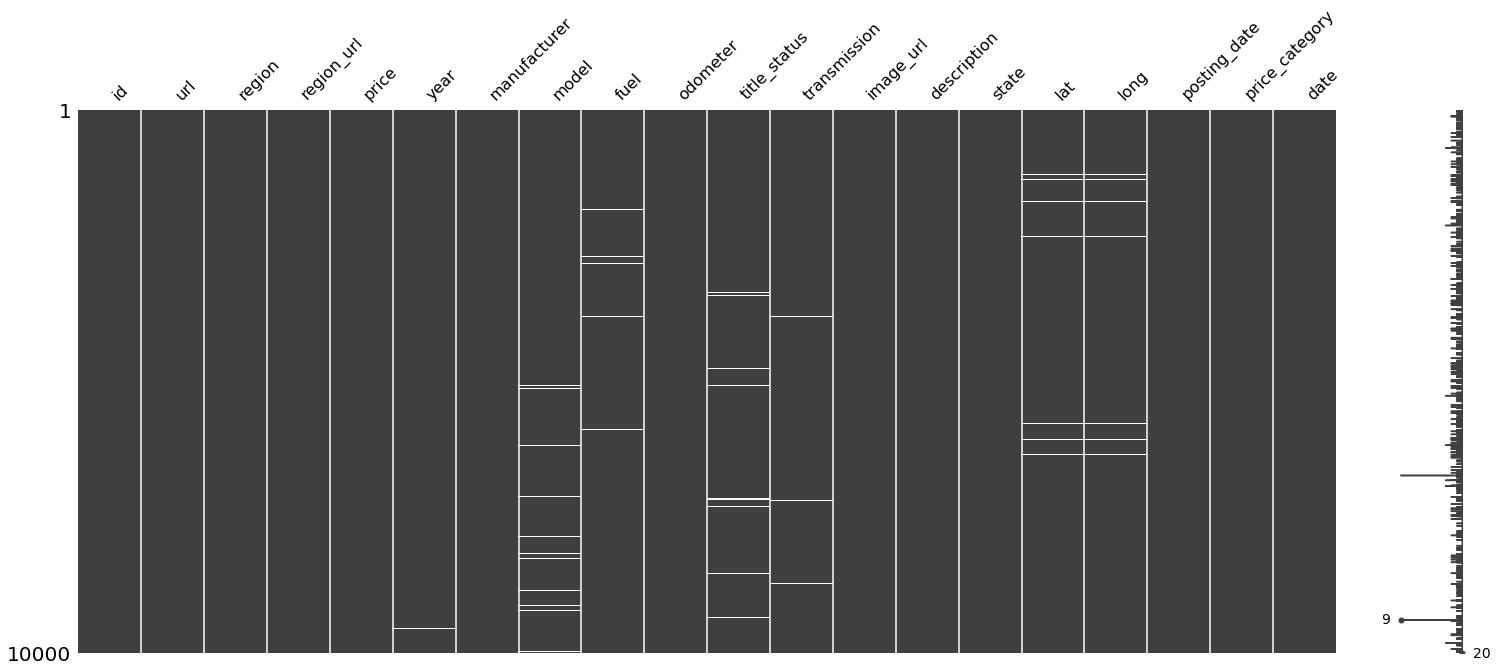

In [5]:
# Визуалзирируем пропуски
msno.matrix(df);

In [6]:
# Выведем процентное количество пропусков по столбцам
(df.isna().sum() / len(df) * 100).sort_values(ascending=False)

title_status      1.66
model             1.28
long              0.98
lat               0.98
fuel              0.63
transmission      0.45
year              0.36
posting_date      0.02
description       0.02
image_url         0.02
date              0.02
url               0.00
odometer          0.00
manufacturer      0.00
state             0.00
price             0.00
region_url        0.00
region            0.00
price_category    0.00
id                0.00
dtype: float64

Обработаем пропуски в признаках, где доля пропусков больше чем 0.1 %

### Обработка пропусков в title_status

In [7]:
# Выведим описательные характеристики статуса автомобиля
df.title_status.describe()

count      9834
unique        6
top       clean
freq       9518
Name: title_status, dtype: object

In [8]:
# Заполним пропуски в статусе автомобиля самым частым значением clean
df_clean = df.copy()
df_clean.title_status.fillna(df_clean.title_status.mode()[0], inplace=True)
print(f'Число пропусков в title_status: {df_clean.title_status.isna().sum()}')

Число пропусков в title_status: 0


### Обработка пропусков в model

In [9]:
# Выведим описательные характеристики модели автомобиля
df.model.describe()

count      9872
unique     3466
top       f-150
freq        151
Name: model, dtype: object

In [10]:
# Заполним пропуски в модели автомобиля значением other
df_clean.model.fillna('other', inplace=True)
print(f'Число пропусков в model: {df_clean.model.isna().sum()}')

Число пропусков в model: 0


### Обработка пропусков в fuel

In [11]:
# Выведим описательные характеристики типа топлива автомобиля
df.fuel.describe()

count     9937
unique       5
top        gas
freq      8402
Name: fuel, dtype: object

In [12]:
# Заполним пропуски в топливе автомобиля самым частым значением gas
df_clean.fuel.fillna(df_clean.fuel.mode()[0], inplace=True)
print(f'Число пропусков в fuel: {df_clean.fuel.isna().sum()}')

Число пропусков в fuel: 0


### Обработка пропусков в transmission

In [13]:
# Выведим описательные характеристики корбок передач автомобиля
df.transmission.describe()

count          9955
unique            3
top       automatic
freq           7700
Name: transmission, dtype: object

In [14]:
# Заполним пропуски в коробке передач самым частым значением automatic
df_clean.transmission.fillna(df_clean.transmission.mode()[0], inplace=True)
print(f'Число пропусков в transmission: {df_clean.transmission.isna().sum()}')

Число пропусков в transmission: 0


### Обработка пропусков в long и lat

In [15]:
# Убедимся, что пропуски в долготе и широте присутсвуют только совместно
ans = (df_clean.long.isna() == df_clean.lat.isna()).sum() == len(df_clean)
print(f'Пропуски в долготе и широте присутствуют только совместно: {ans}')

Пропуски в долготе и широте присутствуют только совместно: True


In [16]:
# Восстановим значение долготы и широты из медианного значения этих параметров по соотвутствующим регионам
region_coords=df_clean.groupby(['region'])['long', 'lat'].median()
# df_clean.long[df_clean.long.isna()] = df_clean.apply(lambda row: region_coords.loc[row.region, 'long'], axis=1)
# df_clean.lat[df_clean.lat.isna()] = df_clean.apply(lambda row: region_coords.loc[row.region, 'lat'], axis=1)

df_clean.loc[df_clean.long.isna(), 'long'] = df_clean.apply(lambda row: region_coords.loc[row.region, 'long'], axis=1)
df_clean.loc[df_clean.lat.isna(), 'lat'] = df_clean.apply(lambda row: region_coords.loc[row.region, 'lat'], axis=1)

print(f'Количество пропусков в long: {df_clean.long.isna().sum()}, количество пропусков в lat: {df_clean.lat.isna().sum()}')

Количество пропусков в long: 0, количество пропусков в lat: 0


### Обработка пропусков в year

In [17]:
# Выведим описательные характеристики для года выпуска автомобиля
df.year.describe()

count    9964.000000
mean     2010.927941
std         9.672040
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [18]:
# Заполним пропуски в годе выпуска автомобиля медианным значением
df_clean.year.fillna(df_clean.year.median(), inplace=True)
print(f'Число пропусков в year: {df_clean.year.isna().sum()}')

Число пропусков в year: 0


### Обработка оставшихся пропусков

In [19]:
# Оценим сколько в скольки % данных остались пропуски
blank_precent = (df_clean.isna().any(axis=1).sum() / len(df_clean)) * 100
print(f'Данные с пропусками составляют {blank_precent} % от всех данных')

Данные с пропусками составляют 0.02 % от всех данных


In [20]:
# Удалим оставшиеся объекты с пропусками
df_clean = df_clean.dropna()

In [21]:
# Убедимся, что пропусков больше нет
df_clean.isna().sum()

id                0
url               0
region            0
region_url        0
price             0
year              0
manufacturer      0
model             0
fuel              0
odometer          0
title_status      0
transmission      0
image_url         0
description       0
state             0
lat               0
long              0
posting_date      0
price_category    0
date              0
dtype: int64

## Преобразование типов данных

In [22]:
# Посмотрим на типы данных в датасете
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9998 non-null   int64  
 1   url             9998 non-null   object 
 2   region          9998 non-null   object 
 3   region_url      9998 non-null   object 
 4   price           9998 non-null   int64  
 5   year            9998 non-null   float64
 6   manufacturer    9998 non-null   object 
 7   model           9998 non-null   object 
 8   fuel            9998 non-null   object 
 9   odometer        9998 non-null   int64  
 10  title_status    9998 non-null   object 
 11  transmission    9998 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           9998 non-null   object 
 15  lat             9998 non-null   float64
 16  long            9998 non-null   float64
 17  posting_date    9998 non-null   o

### Преобразование типов данных для числовых признаков

In [23]:
# Преобразуем типы данных для price, odometer и year
df_clean.price = df_clean.price.astype(float)
df_clean.odometer = df_clean.odometer.astype(float)
df_clean.year = df_clean.year.astype(int)

### Преобразование типов данных к datetime

In [24]:
# Посмотрим на формат признака date
df_clean.date

0       2021-04-17 16:30:50+00:00
1       2021-05-03 19:40:21+00:00
2       2021-04-28 10:52:20+00:00
3       2021-04-17 14:08:57+00:00
4       2021-05-03 22:32:06+00:00
                  ...            
9995    2021-04-10 20:33:57+00:00
9996    2021-05-03 13:36:30+00:00
9997    2021-04-22 19:14:01+00:00
9998    2021-04-14 14:14:42+00:00
9999    2021-04-24 17:50:49+00:00
Name: date, Length: 9998, dtype: object

In [25]:
# Преобразуем date к datetime-типу
df_clean.date = pd.to_datetime(df_clean.date)

In [26]:
# Посмотрим на формат признака posting_date
df_clean.posting_date

0       2021-04-17T12:30:50-0400
1       2021-05-03T15:40:21-0400
2       2021-04-28T03:52:20-0700
3       2021-04-17T10:08:57-0400
4       2021-05-03T18:32:06-0400
                  ...           
9995    2021-04-10T16:33:57-0400
9996    2021-05-03T09:36:30-0400
9997    2021-04-22T12:14:01-0700
9998    2021-04-14T09:14:42-0500
9999    2021-04-24T13:50:49-0400
Name: posting_date, Length: 9998, dtype: object

In [27]:
# Преобразуем posting_date к datetime-типу, оставив только год, месяц и день
df_clean.posting_date = df_clean.posting_date.apply(lambda s: dt.datetime.strptime(s.split('T')[0], '%Y-%m-%d'))

In [28]:
# Еще раз посмотрим на итоговые типы данных
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9998 non-null   int64              
 1   url             9998 non-null   object             
 2   region          9998 non-null   object             
 3   region_url      9998 non-null   object             
 4   price           9998 non-null   float64            
 5   year            9998 non-null   int32              
 6   manufacturer    9998 non-null   object             
 7   model           9998 non-null   object             
 8   fuel            9998 non-null   object             
 9   odometer        9998 non-null   float64            
 10  title_status    9998 non-null   object             
 11  transmission    9998 non-null   object             
 12  image_url       9998 non-null   object             
 13  description     9998 non-null   o

## Анализ выбросов

### Анализ выбросов в price

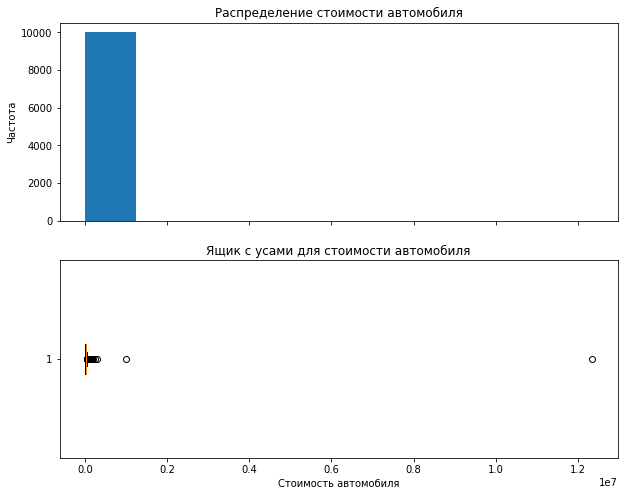

In [29]:
fig, [ax1, ax2] = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)
ax1.hist(df_clean.price)
ax1.set_ylabel('Частота')
ax1.set_title('Распределение стоимости автомобиля')
ax2.boxplot(df_clean.price, vert=False)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.set_xlabel('Стоимость автомобиля')
ax2.set_title('Ящик с усами для стоимости автомобиля')
plt.show()

***Выбросы в price явно есть***

In [30]:
# Найдем границы межквартильного разамаха
q25, q75 = df_clean.price.quantile([0.25, 0.75])
iqr = q75 - q25
boundaries = (q25 - 1.5*(q75 - q25), q75 + 1.5*(q75 - q25))
print(f'Границы: {boundaries}')
print(f'Минимум входит в диапозон: {df_clean.price.min() >= boundaries[0]}')
print(f'Максимум входит в диапозон: {df_clean.price.max() <= boundaries[0]}')

Границы: (-22235.0, 58125.0)
Минимум входит в диапозон: True
Максимум входит в диапозон: False


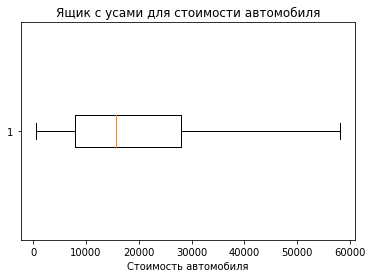

In [31]:
# Заменим выбросы на максимальное значение и убедимся, что выбросов не осталось
df_clean.price[df_clean.price > boundaries[1]] = boundaries[1]
plt.boxplot(df_clean.price, vert=False)
plt.xlabel('Стоимость автомобиля')
plt.title('Ящик с усами для стоимости автомобиля')
plt.show()

### Анализ выбросов в odometer

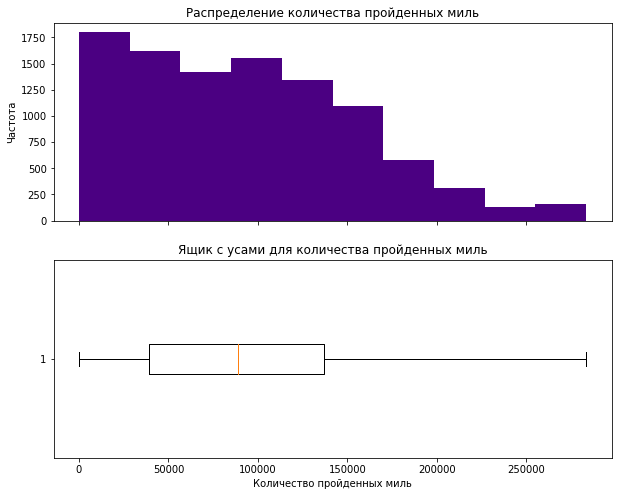

In [32]:
fig, [ax1, ax2] = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)
ax1.hist(df_clean.odometer, color='indigo')
ax1.set_ylabel('Частота')
ax1.set_title('Распределение количества пройденных миль')
ax2.boxplot(df_clean.odometer, vert=False)
ax2.set_xlabel('Количество пройденных миль')
ax2.set_title('Ящик с усами для количества пройденных миль')
plt.show()

***В признаке odometer выбросов нет***

### Анализ выбросов в year

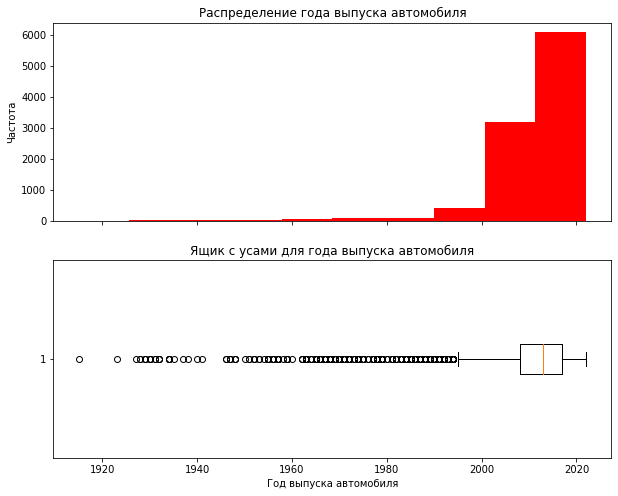

In [33]:
fig, [ax1, ax2] = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)
ax1.hist(df_clean.year, color='red')
ax1.set_ylabel('Частота')
ax1.set_title('Распределение года выпуска автомобиля')
ax2.boxplot(df_clean.year, vert=False)
ax2.set_xlabel('Год выпуска автомобиля')
ax2.set_title('Ящик с усами для года выпуска автомобиля')
plt.show()

***Аномальные значения в year присутствуют, но стоит ли их удалять?***

In [34]:
# Отделим от выборки аномалии
q25, q75 = df_clean.year.quantile([0.25, 0.75])
iqr = q75 - q25
boundaries = (q25 - 1.5*(q75 - q25), q75 + 1.5*(q75 - q25))
print(f'Границы: {boundaries}')
df_group_year = df_clean.groupby(['year'], as_index=False).agg({'price': 'mean', 'odometer': 'mean'})
df_group_year.rename(columns={'price': 'mean_price', 'odometer': 'mean_odometer'}, inplace=True)
is_in = df_group_year.year.between(boundaries[0], boundaries[1])
df_in = df_group_year[is_in]
df_out = df_group_year[~is_in]

Границы: (1994.5, 2030.5)


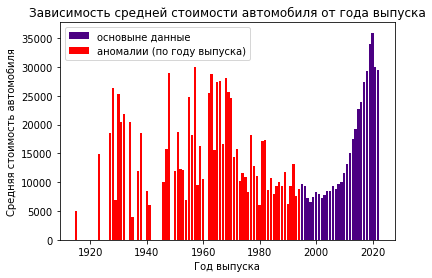

In [35]:
# Построим диаграмму зависимости средней стоимости автомобиля от года выпуска
plt.bar(df_in.year, df_in.mean_price, label='основыне данные', color='indigo')
plt.bar(df_out.year, df_out.mean_price, label='аномалии (по году выпуска)', color='red')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя стоимость автомобиля')
plt.title('Зависимость средней стоимости автомобиля от года выпуска')
plt.legend()
plt.show()

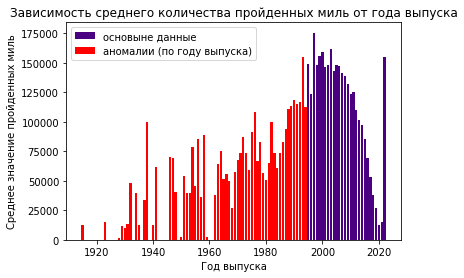

In [36]:
# Построим диаграмму зависимости среднего пробега автомобиля от года выпуска
plt.bar(df_in.year, df_in.mean_odometer, label='основыне данные', color='indigo')
plt.bar(df_out.year, df_out.mean_odometer, label='аномалии (по году выпуска)', color='red')
plt.xlabel('Год выпуска')
plt.ylabel('Среднее значение пройденных миль')
plt.title('Зависимость среднего количества пройденных миль от года выпуска')
plt.legend()
plt.show()

***На данном этапе не будем обрабатывать выбросы в годе выпуска автомобиля***

# Feature Engineering

## Создание дополнительных фичей

In [37]:
df_prepared = df_clean.copy()

# Создадим фичу с количеством слов в описании автомобиля
df_prepared['desc_words'] = df_prepared.description.apply(lambda s: len(s.split()))

# Создадим фичу с годом размещения объявления
df_prepared['posting_year'] = df_prepared.posting_date.apply(lambda d: d.year)

In [38]:
# Просмотрим количество уникальных элементов в категориальных признаках
for col in ('region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'state', 'price_category'):
    print(f'В {col} - {df_prepared[col].nunique()} уникальных элементов')

В region - 393 уникальных элементов
В manufacturer - 40 уникальных элементов
В model - 3467 уникальных элементов
В fuel - 5 уникальных элементов
В title_status - 6 уникальных элементов
В transmission - 3 уникальных элементов
В state - 51 уникальных элементов
В price_category - 3 уникальных элементов


В model слишком много уникальных элементов, создадим признак с первым словом из модели

In [39]:
# Создадим признка short_model и выведем количество его уникальных элементов
df_prepared['short_model'] = df_prepared.model.apply(lambda n: n.split()[0])
df_prepared.short_model.nunique()

989

In [40]:
# Выведим список всех фичей
initial_features = df_prepared.columns
print(f'Список фичей: {initial_features}')

Список фичей: Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer', 'title_status', 'transmission',
       'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
       'price_category', 'date', 'desc_words', 'posting_year', 'short_model'],
      dtype='object')


## Подготовка категориальных признаков

In [41]:
# Выберем следующие категориальные признаки для обучения и создадим объект OneHotEncoder для их преобразования
categorical_features = ['manufacturer', 'short_model', 'fuel', 'title_status', 'transmission']
ohe = OneHotEncoder(sparse=False)
ohe.fit(df_prepared[categorical_features])

OneHotEncoder(sparse=False, sparse_output=False)

In [42]:
# Получим и запишем новые категориальные фичи в датасет и посомтрим их количество
categorical_data = ohe.transform(df_prepared[categorical_features])
print(f'Количество ohe фичей: {categorical_data.shape[1]}')
df_prepared[ohe.get_feature_names_out()] = categorical_data

Количество ohe фичей: 1043


## Подготовка числовых признаков

In [43]:
# Выберем следующие числовые признаки для обучения и создадим объект StandardScaler для их преобразования
numeric_features = ['price', 'year', 'odometer', 'lat', 'long', 'desc_words', 'posting_year']
std_scaler = StandardScaler()
std_scaler.fit(df_prepared[numeric_features])

StandardScaler()

In [44]:
# Получим и запишем новые числовые фичи в датасет
numeric_data = std_scaler.transform(df_prepared[numeric_features])
new_numeric_features = ['std_' + name for name in numeric_features]
df_prepared[new_numeric_features] = numeric_data

## Подготовка финального датасета

In [45]:
# Для финального датасета удалим все необработанные признаки (их названия находятся в initial_features)
df_prepared_final = df_prepared.drop(columns=initial_features)

# Мы также удалили и целевой признак, добавим его заного
df_prepared_final['price_category'] = df_prepared['price_category']
df_prepared_final.to_csv('data/dataset_for_modeling.csv')

# Modeling

## Подготовка данных для обучения

In [46]:
# Удалим из фичей price, чтобы было поинтересней
x = df_prepared_final.drop(['price_category', 'std_price'], axis=1)
y = df_prepared_final['price_category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Модель логистической регрессии

In [47]:
# Создадим базовую модель логистической регрессии, обучим ее и оценим accuracy на тестовой выборке
base_logreg = LogisticRegression(random_state=42)
base_logreg.fit(x_train, y_train)
y_pred = base_logreg.predict(x_test)
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred)}')
print(f'Матрица ошибок:\n {confusion_matrix(y_test, y_pred)}')

Accuracy на тестовой выборке: 0.7516666666666667
Матрица ошибок:
 [[889  35 164]
 [ 38 762 151]
 [152 205 604]]


In [48]:
# Поизведем тюнинг модели логистической регресии
tuning_logreg = LogisticRegression(random_state=42)
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [1, 5, 10], 'solver': ['newton-cg', 'sag']}
grid_search_logreg = GridSearchCV(
    estimator=tuning_logreg,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_logreg.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'sag']},
             scoring='accuracy')

In [49]:
bp = grid_search_logreg.best_params_
print(f'Лучшие параметры для модели логистической регресии: {bp}')
best_logreg = LogisticRegression(random_state=42, penalty=bp['penalty'], C=bp['C'], solver=bp['solver'])
best_logreg.fit(x_train, y_train)
y_pred_logreg = best_logreg.predict(x_test)
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred_logreg)}')
print(f'Матрица ошибок:\n {confusion_matrix(y_test, y_pred_logreg)}')

Лучшие параметры для модели логистической регресии: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy на тестовой выборке: 0.7673333333333333
Матрица ошибок:
 [[895  26 167]
 [ 36 770 145]
 [149 175 637]]


## Модель случайного леса

In [50]:
# Создадим базовую модель случайного леса, обучим ее и оценим accuracy на тестовой выборке
base_rfc = RandomForestClassifier(random_state=42)
base_rfc.fit(x_train, y_train)
y_pred = base_logreg.predict(x_test)
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred)}')
print(f'Матрица ошибок:\n {confusion_matrix(y_test, y_pred)}')

Accuracy на тестовой выборке: 0.7516666666666667
Матрица ошибок:
 [[889  35 164]
 [ 38 762 151]
 [152 205 604]]


In [51]:
# Поизведем тюнинг модели случайного леса
tuning_rfc = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': list(range(100, 401, 100)), 'criterion': ['gini', 'log_loss'], 'min_samples_split': [2, 4, 6]}
grid_search_rfc = GridSearchCV(
    estimator=tuning_rfc,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_rfc.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'log_loss'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [52]:
bp = grid_search_rfc.best_params_
print(f'Лучшие параметры для модели случайного леса: {bp}')
best_rfc = RandomForestClassifier(random_state=42, n_estimators=bp['n_estimators'], criterion=bp['criterion'], min_samples_split=bp['min_samples_split'])
best_rfc.fit(x_train, y_train)
y_pred_rfc = best_rfc.predict(x_test)
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred_rfc)}')
print(f'Матрица ошибок:\n {confusion_matrix(y_test, y_pred_rfc)}')

Лучшие параметры для модели случайного леса: {'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 200}
Accuracy на тестовой выборке: 0.7933333333333333
Матрица ошибок:
 [[932  21 135]
 [ 29 798 124]
 [147 164 650]]


## Модель многослойного персептрона

In [53]:
# Создадим базовую модель многослойного перспетрона, обучим ее и оценим accuracy на тестовой выборке
base_mlp = MLPClassifier(random_state=42)
base_mlp.fit(x_train, y_train)
y_pred = base_mlp.predict(x_test)
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred)}')
print(f'Матрица ошибок:\n {confusion_matrix(y_test, y_pred)}')

Accuracy на тестовой выборке: 0.797
Матрица ошибок:
 [[926  23 139]
 [ 29 772 150]
 [134 134 693]]


In [54]:
# Поизведем тюнинг модели линейного персептрона
tuning_mlp = MLPClassifier(random_state=42)
param_grid = {'activation': ['logistic', 'tanh'], 'hidden_layer_sizes': [(100,), (100, 100)]}
grid_search_mlp = GridSearchCV(
    estimator=tuning_mlp,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_mlp.fit(x_train, y_train)

GridSearchCV(estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh'],
                         'hidden_layer_sizes': [(100,), (100, 100)]},
             scoring='accuracy')

In [55]:
bp = grid_search_mlp.best_params_
print(f'Лучшие параметры для модели линейного персептрона: {bp}')
best_mlp = MLPClassifier(random_state=42, activation=bp['activation'], hidden_layer_sizes=bp['hidden_layer_sizes'])
best_mlp.fit(x_train, y_train)
y_pred_mlp = best_mlp.predict(x_test)
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred_mlp)}')
print(f'Матрица ошибок:\n {confusion_matrix(y_test, y_pred_mlp)}')

Лучшие параметры для модели линейного персептрона: {'activation': 'logistic', 'hidden_layer_sizes': (100, 100)}
Accuracy на тестовой выборке: 0.811
Матрица ошибок:
 [[915  15 158]
 [ 24 780 147]
 [101 122 738]]


## Выбор модели классификации

In [56]:
models = zip([best_logreg, best_rfc, best_mlp], ['best_logreg', 'best_rfc', 'best_mlp'])
for model, name_model in models:
    cv_score = cross_val_score(model, x, y, cv=5)
    print(f'{name_model}. mean: {cv_score.mean()}, std: {cv_score.std()}')

best_logreg. mean: 0.7736547273636818, std: 0.004523248066724807
best_rfc. mean: 0.7986594797398701, std: 0.006810449937250148
best_mlp. mean: 0.8179631315657829, std: 0.0057867249419691425


Лучший результат показала модель многослойного персептрона

In [57]:
best_mlp.fit(x_train, y_train)
acc_train = accuracy_score(y_train, best_mlp.predict(x_train))
acc_test = accuracy_score(y_test, best_mlp.predict(x_test))
print(f'accuracy на тренировочных данных {acc_train}')
print(f'accuracy на тестовых данных {acc_test}')

accuracy на тренировочных данных 0.8901114604172621
accuracy на тестовых данных 0.811


# Results

Лучше всего с задачей классификации на приведенных данных справляется ***модель линейного персептрона***

In [58]:
#Обучим модель на всем датасете и сохраним ее в файл best_model.pkl
best_mlp.fit(x, y)
with open('models/best_model.pkl', 'wb') as file:
    dill.dump(best_mlp, file)